<div style="padding:20px;color:#6A79BA;margin:0;font-size:180%;text-align:center;display:fill;border-radius:5px;background-color:white;overflow:hidden;font-weight:600">Series de tiempo en Hopp</div>

<img src="https://metadata.fundacionsadosky.org.ar/media/media/images/HOPP_-_Flyer_web_metadata.png" style="border-radius:5px">

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">1 | Introducción</div>

Para cualquier empresa, la previsión financiera es vital, particularmente para pequeñas empresas o empresas en rápido crecimiento, donde el flujo de dinero es crucial para su operación y mantenimiento.

Una empresa de préstamos al consumo como Hopp es una institución comercial o financiera que otorga crédito a individuos, con la expectativa de que se reembolsará el monto total del préstamo, más intereses. La ganancia para la empresa son los intereses generados por el crédito, que constituyen un porcentaje específico del capital total del préstamo otorgado al prestatario. El pago del préstamo ocurre en pagos mensuales o quincenales, con la posibilidad de adelantar cuotas.

Dentro de los tipos de préstamo que ofrece Hopp, uno de sus productos más populares son los préstamos de día de pago (PDL, por su nombre en inglés payday loans). Estos son préstamos de relativamente poco capital (comparado con, por ejemplo, una hipoteca) que se otorgan a una tasa de interés elevada por el riesgo de que el préstamo entre en mora y el monto prestado no sea cobrado. Hopp apostó a este tipo de mercado para crecer rápido ya que se trataba de un grupo de personas que comúnmente no suelen ser atendidas por la banca tradicional. La tasa de interés elevada permite compensar el alto riesgo de pago. En caso de no pagar, el interés acumula deuda y puede perjudicar el puntaje crediticio del prestatario.

El objetivo de la competencia es, utilizando datos históricos de pagos de Hopp (enero 2019 - junio 2020), <b>predecir los pagos de principal</b> para cada préstamo activo.

Para mas detalles sobre los files y la descripción del problema ir a este [link](https://metadata.fundacionsadosky.org.ar/competition/26/)

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">2 | Enfoque de la solución</div>

Todo el desarrollo de la solución fue puro feature engineering, buscando variables que dado un punto en el tiempo puedan aportar la mayor información posible respecto del monto principal a estimar.

También se buscó, con muchas complicaciones, un set de validación confiable que genere algún tipo de correlación con el leaderboard. La mejor opción fue utilizar los primeros meses del set para entrenar (hasta abril 2019) y validar contra el resto de la data disponible, esto se hizo buscando emular el comportamiento que luego se busca al momento del submit, es decir, tener predicciones muy lejanas en el tiempo (en este caso contabamos con 13 meses a futuro). Luego incluso se calculaba el mae sólo para el primer semestre de 2020 y se sacaban conclusiones con esa métrica. La idea principal de esto es que el modelo no se degrade fuertemente con el paso del tiempo.

Una vez obtenidas las mejoras contra el set de validación se entrenaba un modelo con la data completa y se realizaba la predicción a submitear.

El modelo utilizado es [LightGBM](https://lightgbm.readthedocs.io/en/v3.3.2/) que es un algoritmo de gradient boosting muy utilizado para este tipo de problemas.

A medida que vayamos transitando la notebook la idea es ir detallando un poco mas cada parte del código ejecutado. Se han dejado comentadas parte de las pruebas realizadas sin mejoras.



# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">3 | Obteniendo Data</div>


In [1]:
import json
import math

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

USE_PRECOMPUTED = False
TUNE_PARAMETERS = False

In [2]:
root_folder = '../'
project_folder = root_folder+'submissions/'
public_drive_folder = root_folder+'data/'
version = 'v15'

if (not USE_PRECOMPUTED):
  # agencies = pd.read_csv(public_drive_folder+'loan_agency_product_name.csv')
  dindexdto = pd.read_csv(public_drive_folder+'loan_dindexedto_dataset.csv')
  loans_info = pd.read_csv(public_drive_folder+'loan_funding_origination_info.csv')
  payments = pd.read_csv(public_drive_folder+'loan_payments_dataset.csv')
payments_scoring = pd.read_csv(public_drive_folder+'loan_payments_dataset_scoring.csv',header=None)
payments_scoring.columns = ['PaymentCode','PaymentPrincipal']

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">4 | Funciones</div>


### Parseo file de submissions

In [3]:
def scoring_fe(ori):
  """Dado el set de datos de submit devuelve un data frame con PaymentType, PaymentProcessingDate, LoanId

  Args:
      ori (pd.DataFrame): loan_payments_dataset_scoring.csv

  Returns:
      pd.DataFrame: data frame con PaymentType, PaymentProcessingDate, LoanId 
  """  
  df = ori.copy()

  df['PaymentCode'] = df['PaymentCode'].astype(str)

  # Begins with 13
  condition_13 = df.PaymentCode.str[0:2]=='13'
  df.loc[condition_13,'PaymentType'] = '13'
  df.loc[condition_13,'PaymentProcessingDate'] = '20' + df.loc[condition_13].PaymentCode.str[2:8]
  df.loc[condition_13,'LoanId'] = df.loc[condition_13].PaymentCode.str[8:]
  # Begins with 4
  condition_4 = df.PaymentCode.str[0:1]=='4'
  df.loc[condition_4,'PaymentType'] = '4'
  df.loc[condition_4,'PaymentProcessingDate'] = '20' + df.loc[condition_4].PaymentCode.str[1:7]
  df.loc[condition_4,'LoanId'] = df.loc[condition_4].PaymentCode.str[7:]
  # Begins with 8
  condition_8 = df.PaymentCode.str[0:1]=='8'
  df.loc[condition_8,'PaymentType'] = '8'
  df.loc[condition_8,'PaymentProcessingDate'] = '20' + df.loc[condition_8].PaymentCode.str[1:7]
  df.loc[condition_8,'LoanId'] = df.loc[condition_8].PaymentCode.str[7:]
  # Begins with 12
  condition_12 = df.PaymentCode.str[0:2]=='12'
  df.loc[condition_12,'PaymentType'] = '1'
  df.loc[condition_12,'PaymentProcessingDate'] = '20' + df.loc[condition_12].PaymentCode.str[1:7]
  df.loc[condition_12,'LoanId'] = df.loc[condition_12].PaymentCode.str[7:]
  # Begins with 20 or 21
  condition_20_21 = (df.PaymentCode.str[0:2]=='20') | (df.PaymentCode.astype(str).str[0:2]=='21')
  df.loc[condition_20_21,'PaymentType'] = '0'
  df.loc[condition_20_21,'PaymentProcessingDate'] = '20' + df.loc[condition_20_21].PaymentCode.str[0:6]
  df.loc[condition_20_21,'LoanId'] = df.loc[condition_20_21].PaymentCode.str[6:]
  # Begins with 22
  condition_22 = (df.PaymentCode.str[0:2]=='22')
  df.loc[condition_22,'PaymentType'] = '2'
  df.loc[condition_22,'PaymentProcessingDate'] = '20' + df.loc[condition_22].PaymentCode.str[1:7]
  df.loc[condition_22,'LoanId'] = df.loc[condition_22].PaymentCode.str[7:]
  

  df['PaymentProcessingDate'] = df['PaymentProcessingDate'].str[0:4] + '-' + df['PaymentProcessingDate'].str[4:6] + '-' + df['PaymentProcessingDate'].str[6:8]
  df['PaymentType'] = df['PaymentType'].astype(object)
  df['PaymentCode'] = df['PaymentCode'].astype(int)
  df['LoanId'] = df['LoanId'].astype(int)
  #df.drop(columns=['PaymentPrincipal'],inplace=True)

  return df

### Feature Enginneering

In [4]:
def get_mean_from_train(df, col_to_aggregate=None, var_to_aggregate='PrincipalVsQuote'):
  """Genera promedios desde la data de train. 
  Si no se indica ninguna columna en col_to_aggregate ni en var_to_aggregate se calcula la tabla de amortización,
  es decir para un tipo de pago (PaymentType), duración de préstamo (Term), periodicidad de pago (PaysPerMonth)
  y meses desde el origen (MonthsFromOri) se calcula la media de principal vs valor de la cuota (PrincipalVsQuote).
  De lo contrario se calcula para esa columna informada mas el PaymentType se calcula la media de la variable
  informada en var_to_aggregate.

  Args:
      df (pd.DataFrame): set de datos con las columnas mencionadas
      col_to_aggregate (str, optional): nombre columna a agrupar. Defaults to None.
      var_to_aggregate (str, optional): columna a calcular el promedio. Defaults to 'PrincipalVsQuote'.

  Returns:
      pd.Series: si col_to_aggregate es null la serie PrincipalVsQuote_perQuoteMean, si no una columna con 
      el nombre col_to_aggregate+var_to_aggregate+'_mean
  """  
  if (col_to_aggregate is None):
    to_group = ['PaymentType','Term','PaysPerMonth','MonthsFromOri']
    col_to_aggregate=''
    preffix = '_perQuoteMean'
  else:
    to_group = [col_to_aggregate] + ['PaymentType']
    preffix = '_mean'
  aux = df[df['SetType'] == 'Train'].groupby(to_group)[var_to_aggregate].agg({('avg','mean'),('n','count')}).reset_index()
  aux.loc[aux['n']<100, 'avg'] = None
  aux.drop(columns=['n'],inplace=True)
  aux.rename(columns={"avg": col_to_aggregate+var_to_aggregate+preffix}, inplace=True)
  return aux

In [5]:
def complete_dueDate(loan,index_dates):
  """DEPRECADO. Imputa fechas de vencimiento de cuota nulas

  Args:
      loan (pd.SeriesGroupBy): serie agrupada de un loan
      index_dates (_type_): dateindex full para todas las fechas de vencimiento

  Returns:
      pd.Series: serie con la variable CompletePaymentDueDate imputada
  """  
  aux = loan['PreviousTransferDate'].apply(lambda x: index_dates[index_dates>=x].head(1).values[0] if pd.notnull(x) else None)
  loan.loc[loan.CompletePaymentDueDate.isna(),'CompletePaymentDueDate'] = aux
  return loan

In [6]:
def get_loan_vars(df, vars_dict, rolling_window=100):
  """Genera variables del loan segun su historico de pagos. Si no se indica una ventana de tiempo se generan variables
  históricas de comportamiento, de lo contrario se observan rolling_window filas hacia atras.

  Args:
      df (pd.DataFrame): set de datos
      vars_dict (dict): diccionario con variables y agregaciones a aplicar
      rolling_window (int, optional): indica la cantidad de filas a considerar para el calculo. Defaults to 100.

  Returns:
      pd.DataFrame: devuelve el set de datos con las nuevas columnas agregadas
  """  
  if rolling_window==100:
    rolling_name = '_historical_'
  else:
    rolling_name = '_rolling'+str(rolling_window)+'_'

  df = df.sort_values(by=['LoanId','PaymentProcessingDate'])
  grouped = df[df.PaymentType.isin([0,2])].groupby('LoanId')
  for i in vars_dict:
   print("Calculating "+i+ " aggregations..")
   for j in vars_dict[i]:
     var_name = i+rolling_name+j
     print('\t'+var_name)
     if(j == 'max'):
       df[var_name] = grouped[i].transform(lambda x: x.rolling(window=rolling_window, min_periods=1).max().shift())
     elif(j=='mean'):
       df[var_name] = grouped[i].transform(lambda x: x.rolling(window=rolling_window, min_periods=1).mean().shift())
     elif(j=='min'):
       df[var_name] = grouped[i].transform(lambda x: x.rolling(window=rolling_window, min_periods=1).min().shift())
     elif(j=='count'):
       df[var_name] = grouped[i].transform(lambda x: x.rolling(window=rolling_window, min_periods=1).count().shift()) 
     elif(j=='median'):
       df[var_name] = grouped[i].transform(lambda x: x.rolling(window=rolling_window, min_periods=1).median().shift()) 
       
  return df

A continuacion encontraremos la función principal, su input los files originales, su output el dataset con las variables nuevas a utilizar por el modelo.

La misma función admite setear un set de validación y/o un set de test devolviendo un data frame con toda la data. Para diferenciar cada tipo de datos se crea la variable SetType con valores posibles Train, Validation y Test

In [7]:
def fe(df, loan_info, dindex, scoring=None, validation_set=None):
  """Funcion principal de feature engineering. Recibe los sets de datos originales y devuelve un set de datos
  con las variables calculadas para realizar el entrenamiento.
  El campo scoring es opcional, si se indica se calculan las variables tambien para el set de datos final.
  El campo validation_set también es opcional, de in

  Args:
      df (pd.DataFrame): set de datos de pagos
      loan_info (pd.DataFrame): set de datos de info de loans
      dindex (pd.DataFrame): set de datos de info de tipo de indexación
      scoring (pd.DataFrame, optional): set de datos con filas a predecir. Defaults to None.
      validation_set (pd.DataFrame, optional): set de datos de pagos para utilizar de validación. Defaults to None.

  Returns:
      pd.DataFrame: set de datos final
  """  
  
  df['SetType'] = 'Train'
  df['PaymentCode'] = None

  # remove negative principal (106 rows)
  df = df[df.PaymentPrincipal>=0].reset_index(drop=True)

  # If have validation set, put into None DueDate 
  if validation_set is not None:
    validation_set['PaymentDueDate'] = None
    validation_set['SetType'] = 'Validation'
    df = pd.concat([df,validation_set]).reset_index(drop=True)

  # date columns
  date_cols = ['PaymentProcessingDate','PaymentDueDate','PaymentTransferDate']
  for i in date_cols:
    df[i] = pd.to_datetime(df[i])

  # aggrupate multiple pays for one loan, paymenttype, processingdate
  df = df.groupby(['LoanId','PaymentSource','PaymentType','PaymentProcessingDate','SetType'],dropna=False).agg(
      {'PaymentPrincipal':[('PaymentPrincipal','sum'),('PaymentPrincipal_npayments','count')],
       'PaymentTransferDate':[('PaymentTransferDate','max')],
       'PaymentDueDate':[('PaymentDueDate','min'),('PaymentDueDate_nunique','nunique')]})
  df.columns = df.columns.droplevel(level=0)
  df = df.reset_index()

  df = df.sort_values(by=['LoanId','PaymentTransferDate','PaymentProcessingDate'])

  # If have validation set, save PaymentPrincipal values before set it to None 
  if validation_set is not None:
    valid_target = df.loc[df['SetType'] == 'Validation','PaymentPrincipal']
    df.loc[df['SetType'] == 'Validation','PaymentPrincipal'] = None
  
  # payment type fix -> move all to PaymentType
  df['PaymentSource'] = df['PaymentSource'].map({'Regular':0, 'Alternative':1,'Contractor':2})
  df['PaymentType'] = df['PaymentType'].fillna(df['PaymentSource'])
  

  # Attach scoring test set
  if scoring is not None:
    scoring = scoring_fe(scoring)
    #scoring = scoring[scoring.LoanId.isin(df.LoanId.unique())].reset_index(drop=True)
    scoring['SetType'] = 'Test'
    df = pd.concat([df,scoring]).reset_index(drop=True)
  
  # add loan info
  df = df.merge(loan_info, how='left')
  
  # add index info
  df = df.merge(dindex, how='left')

  # date columns
  date_cols = ['PaymentProcessingDate','PaymentDueDate','PaymentTransferDate','OriginationDate']
  for i in date_cols:
    df[i] = pd.to_datetime(df[i])

  df = df.sort_values(by=['LoanId','PaymentTransferDate','PaymentProcessingDate'])
  
  # add agency info
  #df = df.merge(agencies, how='left')

  df['AgencyId'] = df['AgencyId'].astype('object')
  df['FundingID'] = df['FundingID'].astype('object')
  df['PaymentType'] = df['PaymentType'].astype(float).astype('object')

  # remove old loans
  # df = df[df.OriginationDate.str[:4].astype(int)>=2010].reset_index(drop=True)

  # exclude loan without result
  #df = df[df.LoanOperationalStatus!='Unidentified'].reset_index(drop=True)

  # exclude loan without loan amount info
  #df = df[df.InstallmentAmount>0].reset_index(drop=True)

  # loan status drop in model 
  #df.drop(columns=['LoanOperationalStatus'],inplace=True)

  # loan duration
  df['Term'] = df['Term'].fillna(1)

  df['PaysPerMonth'] = df['Periodicity'].map({'Monthly':1, 'Biweekly':2,'Weekly':4})
  df['LoanYears'] = df['Term'] / df['PaysPerMonth'] / 12
  df['LoanMonths'] = (df['Term']/df['Periodicity'].map({'Monthly':1, 'Biweekly':2,'Weekly':4})).round().fillna(1).astype(int)
  df['LoanOriginationYear'] = df.OriginationDate.dt.year
  df['LoanOriginationMonth'] = df.OriginationDate.dt.month

  # payment principal
  df['PaymentPrincipal_perPayment'] = df['PaymentPrincipal']/df['PaymentPrincipal_npayments']

  # quote amount
  df['InstallmentQuoteAmount'] = df['InstallmentAmount'] / df['Term'] 
  # replace quote amount 0 per PaymentPrincipal
  df.loc[df['InstallmentQuoteAmount']==0,'InstallmentQuoteAmount'] = df.PaymentPrincipal
 

  # Last Payment Date flag -> without good results
  # df["LastQuoteDate"] = df["OriginationDate"] + df['LoanMonths'].astype('timedelta64[M]')
  # df['PastDueLoanPayment']=(df["LastQuoteDate"]<df["PaymentProcessingDate"])

  # days between payments
  df['PreviousProcessingDate'] = df.groupby('LoanId')['PaymentProcessingDate'].shift()
  df['DaysFromLastPayment'] = (df['PaymentProcessingDate'] - df['PreviousProcessingDate'])/np.timedelta64(1, 'D')
  df['EstimatedNPayedQuota'] = df['DaysFromLastPayment'].apply(lambda x: math.ceil(x/30) if pd.notnull(x) else 1)
   
  # delay payment calculation
  df['DelayPayment'] = (df['PaymentProcessingDate'] - df['PaymentDueDate'])/np.timedelta64(1, 'D')

  # due date impute -> without good results
  # df['CompletePaymentDueDate'] = df['PaymentDueDate']
  # index_dates = pd.date_range('2018-01-01','2022-12-15',freq='SM')
  # index_dates = pd.Series(index_dates,name='PaymentDueDate')
  # df = df.groupby('LoanId').apply(lambda x: complete_dueDate(x, index_dates))
  # df['CompletedDelayPayment'] = (df['PaymentProcessingDate'] - df['CompletePaymentDueDate'])/np.timedelta64(1, 'D')

  

  # months from origination
  df.loc[df.PaymentDueDate.notnull(),'MonthsFromOri'] = (df['PaymentDueDate'] - df['OriginationDate'])/np.timedelta64(1, 'M')
  df.loc[df.PaymentDueDate.isna(),'MonthsFromOri'] = (df['PaymentProcessingDate'] - df['OriginationDate'])/np.timedelta64(1, 'M')
  # df['MonthsFromOri'] = (df['PaymentDueDate'] - df['OriginationDate'])/np.timedelta64(1, 'M')
  df['MonthsFromOri'] = (df['MonthsFromOri'].fillna(-1)).astype(int)
  # little rows with 0 as first month, convert to quote 1
  df.loc[df['MonthsFromOri']==0,'MonthsFromOri'] = 1
  
  df['DueDateDaysFromOri'] = (df['PaymentDueDate'] - df['OriginationDate'])/np.timedelta64(1, 'D')

  df['PrincipalVsQuote'] = df['PaymentPrincipal']/df['InstallmentQuoteAmount']
  
  #df['PrincipalVsAmount'] = df['PaymentPrincipal']/df['PaymentAmount']
  
  # error payments validated with payment_due_date removed
  df = df[(df.DueDateDaysFromOri>-30) | (df.DueDateDaysFromOri.isna())].reset_index(drop=True)

  # means variables
  df = df.merge(get_mean_from_train(df), how='left')
  cols_to_aggregate = ['Type','D-IndexedTo','AgencyId','FundingID']#,'LoanOperationalStatus']
  for i in cols_to_aggregate:
    df = df.merge(get_mean_from_train(df, i), how='left')

  # variables from history
  historical_agg = {
      'DelayPayment':['max','median'],
      'PaymentPrincipal':['max','median','count'],
      'PaymentPrincipal_perPayment':['max','median'],
      'PrincipalVsQuote':['max','median'],
      'PaymentPrincipal_npayments':['max'],
      'PaymentDueDate_nunique':['max'],
      'DaysFromLastPayment':['max','median']
  }
  df = get_loan_vars(df,historical_agg)


  last_months_agg = {
      'DaysFromLastPayment':['max','mean'],
      # 'CompletedDelayPayment':['max','mean'],
  }
  
  # variables from rolling6
  df = get_loan_vars(df,last_months_agg, rolling_window=6)
  # variables from rolling3
  df = get_loan_vars(df,last_months_agg, rolling_window=3)

  df['DiffDaysFromLastPayment_6_3_max'] = df['DaysFromLastPayment_rolling3_max'] / df['DaysFromLastPayment_rolling6_max']
  df['DiffDaysFromLastPayment_6_3_mean'] = df['DaysFromLastPayment_rolling3_mean'] / df['DaysFromLastPayment_rolling6_mean']


  df['PrincipalEstimated'] =  df['PaymentPrincipal_historical_median'] * df['EstimatedNPayedQuota']
  # df = get_loan_vars(df, rolling_window=6)

  # tested variables with worst performance
  # df['AmountVsQuote'] = df['PaymentAmount']/df['InstallmentQuoteAmount']
  # df['InterestVsAmount'] = df['PaymentInterest']/df['PaymentAmount']
  # df['VatVsAmount'] = df['PaymentVAT']/df['PaymentAmount']
  # df = df.merge(get_mean_from_train(df, col_to_aggregate='Type', var_to_aggregate='AmountVsQuote', with_rolling=True), how='left')
  # df = df.merge(get_mean_from_train(df, col_to_aggregate='Type', var_to_aggregate='PrincipalVsAmount', with_rolling=True), how='left')
  # df['WeighedQuoteAmount'] = df['InstallmentQuoteAmount'] * df['TypeAmountVsQuoteRolling7_perQuoteMean']
  # df['WeighedQuoteAmount_perQuote'] = df['WeighedQuoteAmount'] * df['TypePrincipalVsAmountRolling7_perQuoteMean']
  # df = df.merge(get_mean_from_train(df, col_to_aggregate=None, var_to_aggregate='PrincipalVsAmount', with_rolling=False), how='left')
  # df = df.merge(get_mean_from_train(df, col_to_aggregate=None, var_to_aggregate='InterestVsAmount', with_rolling=False), how='left')
  # df = df.merge(get_mean_from_train(df, col_to_aggregate=None, var_to_aggregate='VatVsAmount', with_rolling=False), how='left')
  # df['LoanAdvance'] = df['MonthsFromOri']*2/df['Term']

  # to_group = ['LoanId','PaymentsMonthsFromOri']
  # aux = df.groupby(to_group).size().reset_index()
  # df['MonthsFromLastPayment'] = aux[to_group].groupby('LoanId').transform(lambda x: x.diff())

  # df['PaymentDay'] = df.PaymentProcessingDate.dt.strftime('%m-%d').astype('object')
  # df['PaymentMonth'] = df.PaymentProcessingDate.dt.month.astype('object')
  #df['AgencyProcessingDelay'] = (df['PaymentProcessingDate'] - df['PaymentTransferDate'])/np.timedelta64(1, 'D')

  df.drop(columns=['PaymentSource','ProductName','PaysPerMonth','PreviousProcessingDate'],inplace=True)

  if validation_set is not None:
    df.loc[df['SetType']=='Validation', 'PaymentPrincipal'] = valid_target.values
  
  return df

In [8]:
def set_dates(df):
  """Set de tipo datetime a variables de fecha en el dataset

  Args:
      df (pd.DataFrame): set de datos full

  Returns:
      pd.DataFrame: set de datos con las fechas casteadas
  """  
  # date columns
  date_cols = ['OriginationDate','PaymentProcessingDate','PaymentDueDate','PaymentTransferDate']
  for i in date_cols:
    df[i] = pd.to_datetime(df[i])
  return df

In [9]:
def validate_model(df, 
                date_col, 
                target_col, 
                feat_cols, 
                params):
  """Entrenamiento del modelo contra set de validación

  Args:
      df (pd.DataFrame): set de datos completo
      date_col (str): nombre de la columna de fecha que ordena los registros
      target_col (str): nombre de la columna target
      feat_cols (list): lista de features del modelo
      params (dict): parametros del modelo

  Returns:
      Booster, array: modelo, lista de predicciones
  """  
  train_filter = (df['SetType']=='Train')
  valid_filter = (df['SetType']=='Validation')
  list_str_obj_cols = df[feat_cols].columns[df[feat_cols].dtypes == "object"].tolist()
  for str_obj_col in list_str_obj_cols:
      df[str_obj_col] = df[str_obj_col].astype("category")
  print(f'Categorical columns:{df[feat_cols].columns[df[feat_cols].dtypes == "category"]}')

  X_train, y_train = df.loc[train_filter,feat_cols], df.loc[train_filter, target_col]
  X_valid, y_valid = df.loc[valid_filter,feat_cols], df.loc[valid_filter, target_col]
  X_dates = df.loc[train_filter,date_col]
  valid_dates = df.loc[valid_filter,date_col]

  print("Train Date range: {} to {}".format(X_dates.min(),X_dates.max()))
  print("Valid Date range: {} to {}".format(valid_dates.min(),valid_dates.max()))
  
  lgb_train = lgb.Dataset(X_train, y_train)
  lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

  lgb_results = {}
  gbm = lgb.train(params,
                  lgb_train,
                  valid_sets=[lgb_train, lgb_eval],
                  valid_names=['Train', 'Valid'],
                  verbose_eval=10, 
                  num_boost_round=2000,
                  early_stopping_rounds=50,
                  evals_result=lgb_results)
  print(gbm.best_iteration)
  y_pred = gbm.predict(X_valid)
  mae = mean_absolute_error(y_valid, y_pred)
  print("Best MAE:", mae)

  feat_importance=pd.DataFrame()
  feat_importance["Importance"]=gbm.feature_importance()
  feat_importance.set_index(X_train.columns, inplace=True)


  ################################
  # training chart
  fig = plt.figure(figsize=(15, 10))

  # loss
  plt.subplot(1,2,1)
  loss_train = lgb_results['Train']['l1']
  loss_test = lgb_results['Valid']['l1']   
  plt.xlabel('Iteration')
  plt.ylabel('mae')
  plt.plot(loss_train, label='train mae')
  plt.plot(loss_test, label='valid mae')
  plt.legend()

  # feature importance
  plt.subplot(1,2,2)
  importance = pd.DataFrame({'feature':feat_cols, 'importance':gbm.feature_importance()})
  sns.barplot(x = 'importance', y = 'feature', data = importance.sort_values('importance', ascending=False))

  plt.tight_layout()
  plt.show()
  
  return gbm, y_pred

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">5 | Validación Modelo</div>


### Generar Features con split

Como mencionabamos al inicio de la notebook tomamos los primeros 4 meses de datos para entrenar un modelo y el resto de la data para validar. 

Si no corrimos nunca la notebook usar USE_PRECOMPUTE=False para generar la data, en posteriores corridas podemos utilizar las variables ya calculadas.

In [10]:
train_to = '2019-05-01'
test_to = '2020-07-01'
#loans = pd.Series(payments.LoanId.unique()).sample(10000)
#condition = payments.LoanId.isin(loans)
file_name = project_folder+'df_train'+train_to[:7]+'_test'+test_to[:7]+version+'.csv'
dtypes_name = project_folder+'dtypes_'+version+'_valid.json'
if (USE_PRECOMPUTED):
  df = pd.read_csv(file_name)
  with open(dtypes_name, 'r') as f:
    data_types = json.load(f)
  for k in data_types:
    if k in df.columns and data_types[k]!='datetime64[ns]':
        df[k] = df[k].astype(data_types[k])
  df = set_dates(df)
else:
  train_filter = (payments['PaymentProcessingDate']<=train_to) #& condition
  valid_filter = (payments['PaymentProcessingDate']>train_to) & (payments['PaymentProcessingDate']<test_to) #& condition
  df = fe(payments[train_filter].copy(), loans_info, dindexdto, #agencies,
          validation_set=payments[valid_filter].copy())
  df.to_csv(file_name, index=False)
  with open(dtypes_name, 'w') as f:
      json.dump(df.dtypes.astype(str).to_dict(), f)

### Features 

In [11]:
header_cols = ['LoanId','PaymentProcessingDate','PaymentTransferDate','PaymentDueDate', 'PaymentPrincipal','DelayPayment','SetType', 'PrincipalVsQuote']
model_features = ['PaymentType',
                  'AgencyId',
                  'FundingID',
                  'InstallmentAmount',
                  #'Periodicity',
                  #'LoanOperationalStatus',
                  # 'VAT',
                  'Term',
                  # 'D-IndexedTo',
                  #'Country',
                  'LoanOriginationYear',
                  # 'PaysPerMonth',
                  'LoanMonths',
                  'InstallmentQuoteAmount',
                  'MonthsFromOri',
                  'PrincipalVsQuote_perQuoteMean',
                  'TypePrincipalVsQuote_mean',
                  'D-IndexedToPrincipalVsQuote_mean',
                  'AgencyIdPrincipalVsQuote_mean',
                  'FundingIDPrincipalVsQuote_mean',
                  'DelayPayment_historical_median', 
                  'DelayPayment_historical_max', 
                 
                  'DaysFromLastPayment',
                  'PrincipalEstimated',
                  'EstimatedNPayedQuota',
                  'DaysFromLastPayment_rolling6_mean',
                  'DaysFromLastPayment_rolling6_max',
                  'PaymentPrincipal_historical_median',
                  'PaymentPrincipal_historical_max',
                  'PaymentPrincipal_historical_count',
                  'PaymentPrincipal_perPayment_historical_median',
                  'PaymentPrincipal_perPayment_historical_max',
                  'PrincipalVsQuote_historical_median',
                  'PrincipalVsQuote_historical_max',
                  'DaysFromLastPayment_historical_median',
                  'DaysFromLastPayment_historical_max',
                  
                  'DaysFromLastPayment_rolling3_mean',
                  'DaysFromLastPayment_rolling3_max',
                  'PaymentPrincipal_npayments_historical_max',
                  'PaymentDueDate_nunique_historical_max',
                  'DiffDaysFromLastPayment_6_3_max',
                  'DiffDaysFromLastPayment_6_3_mean',

                  
                  #---Agregar
                  #'Prediction from regression'
]
target = 'PaymentPrincipal'

### Optimización parámetros

Proceso de optimización de hiperparámetros del algortimo, puesto en false por defecto ya que es un poco lento (no mas de 10 min), de aquí salieron los parámetros seteados a continuación.

In [12]:
if (TUNE_PARAMETERS):
    from verstack import LGBMTuner
    
    train_filter = (df['SetType']=='Train')
    valid_filter = (df['SetType']=='Validation')
    list_str_obj_cols = df[model_features].columns[df[model_features].dtypes == "object"].tolist()
    for str_obj_col in list_str_obj_cols:
        df[str_obj_col] = df[str_obj_col].astype("category")
    print(f'Categorical columns:{df[model_features].columns[df[model_features].dtypes == "category"]}')

    X_train, y_train = df.loc[train_filter,model_features], df.loc[train_filter, target]
    X_valid, y_valid = df.loc[valid_filter,model_features], df.loc[valid_filter, target]
    # tune the hyperparameters and fit the optimized model
    tuner = LGBMTuner(metric = 'mae') # <- the only required argument
    tuner.fit(X_train, y_train)
    # check the optimization log in the console.
    pred = tuner.predict(X_valid)
    mae = mean_absolute_error(y_valid, pred)
    print("Best MAE:", mae)
    print(tuner.best_params)

### Parámetros

In [13]:
params =  {
 'learning_rate': 0.05,
 'num_leaves': 242,
 'colsample_bytree': 0.8184760893279794,
 'subsample': 0.5382071904887805,
 'verbosity': -1,
 'random_state': 42,
 'objective': 'regression',
 'metric': 'l1',
 'num_threads': 14,
 'min_sum_hessian_in_leaf': 0.006706207126441575,
 'reg_alpha': 5.3006159843660915e-08,
 'reg_lambda': 0.0008648312997620131,
 'n_estimators': 430
}

### Validación

/tmp/ipykernel_110600/3530236551.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str_obj_col] = df[str_obj_col].astype("category")
/tmp/ipykernel_110600/3530236551.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str_obj_col] = df[str_obj_col].astype("category")
/tmp/ipykernel_110600/3530236551.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

Categorical columns:Index(['PaymentType', 'AgencyId', 'FundingID'], dtype='object')
Train Date range: 2019-01-04 00:00:00 to 2019-04-30 00:00:00
Valid Date range: 2019-05-02 00:00:00 to 2020-06-30 00:00:00


/home/tiago/.pyenv/versions/3.9.12/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/home/tiago/.pyenv/versions/3.9.12/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/tiago/.pyenv/versions/3.9.12/lib/python3.9/site-packages/lightgbm/engine.py:240: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/

Training until validation scores don't improve for 50 rounds
[10]	Train's l1: 239.599	Valid's l1: 446.381
[20]	Train's l1: 168.738	Valid's l1: 395.854
[30]	Train's l1: 126.577	Valid's l1: 368.986
[40]	Train's l1: 101.343	Valid's l1: 354.026
[50]	Train's l1: 86.108	Valid's l1: 346.036
[60]	Train's l1: 76.3108	Valid's l1: 340.922
[70]	Train's l1: 69.9469	Valid's l1: 337.85
[80]	Train's l1: 64.9671	Valid's l1: 335.62
[90]	Train's l1: 61.4478	Valid's l1: 333.882
[100]	Train's l1: 58.4519	Valid's l1: 333.246
[110]	Train's l1: 56.2764	Valid's l1: 333.031
[120]	Train's l1: 54.6781	Valid's l1: 333.472
[130]	Train's l1: 53.2709	Valid's l1: 334.131
[140]	Train's l1: 52.0056	Valid's l1: 334.872
[150]	Train's l1: 50.8984	Valid's l1: 335.92
[160]	Train's l1: 50.0155	Valid's l1: 337.872
Early stopping, best iteration is:
[112]	Train's l1: 55.9891	Valid's l1: 333.027
112
Best MAE: 333.0269485901905


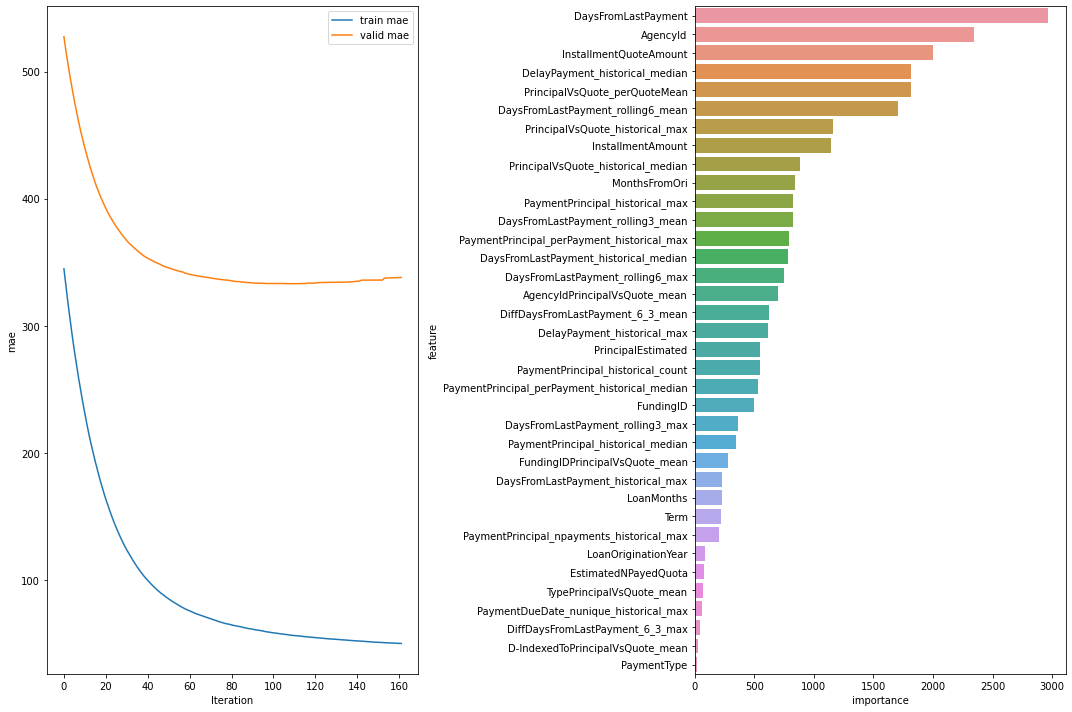

In [14]:
model, preds = validate_model(df[(df.PaymentPrincipal_historical_max.notnull()) | (df.SetType=='Validation')],
                    'PaymentProcessingDate', 
                    target, 
                    model_features, 
                    params)

### Cálculo mae primer semestre 2020

In [15]:
aux = df[df.SetType=='Validation'].reset_index(drop=True)
aux['preds'] = pd.Series(preds,name='preds')
aux = aux[['LoanId','PaymentProcessingDate','PaymentPrincipal','PaymentPrincipal_historical_max', 'PaymentType','InstallmentAmount','preds']]
date_from_filter = (aux.PaymentProcessingDate>'2020-01-01')
mae = mean_absolute_error(aux.loc[date_from_filter,'PaymentPrincipal'], aux.loc[date_from_filter,'preds'])
print("MAE original:", mae)

MAE original: 314.1184048560672


### Análisis mayores diferencias respecto del target

In [16]:
aux['diffReal']=(aux.PaymentPrincipal - aux.preds).abs()
aux['PaymentVsInstallmentAmount']=(aux.PaymentPrincipal / aux.InstallmentAmount)
aux.sort_values(by='diffReal',ascending=False).head(10)

,LoanId,PaymentProcessingDate,PaymentPrincipal,PaymentPrincipal_historical_max,PaymentType,InstallmentAmount,preds,diffReal,PaymentVsInstallmentAmount
850328,669724,2019-06-21,350000.000,NaN,1.000,607800.890,1017.177,348982.823,0.576
741528,661420,2019-08-06,350000.000,NaN,4.000,898176.000,1233.766,348766.234,0.390
689311,657046,2019-12-05,344204.970,NaN,4.000,898176.000,1161.021,343043.949,0.383
828255,668084,2019-05-03,330065.680,NaN,4.000,607800.890,1230.997,328834.683,0.543
890633,672854,2019-06-27,325665.190,NaN,4.000,607800.890,948.703,324716.487,0.536
940978,676835,2019-08-22,324000.000,NaN,4.000,831454.200,948.217,323051.783,0.390
921218,675306,2019-06-21,323500.000,NaN,1.000,561781.680,619.575,322880.425,0.576
874163,671563,2019-11-19,322500.000,NaN,4.000,827604.600,691.410,321808.590,0.390
743359,661562,2019-05-16,320048.160,NaN,4.000,607800.890,940.711,319107.449,0.527
872831,671464,2019-07-26,316530.570,NaN,4.000,607800.890,1171.421,315359.149,0.521


### Mejoras predicciones en función de resultados

In [17]:
aux = df[df.SetType=='Validation'].reset_index(drop=True)
aux['preds'] = pd.Series(preds,name='preds')
aux = aux[['LoanId','PaymentProcessingDate','PaymentPrincipal','PaymentPrincipal_historical_max', 'PaymentType','InstallmentAmount','preds']]
date_from_filter = (aux.PaymentProcessingDate>'2020-01-01')
mae = mean_absolute_error(aux.loc[date_from_filter,'PaymentPrincipal'], aux.loc[date_from_filter,'preds'])
print("MAE original:", mae)

# Mejoras sobre predicciones que son 0 y daban muy cercanas
aux.loc[aux['preds']<25,'preds'] = 0
mae = mean_absolute_error(aux.loc[date_from_filter,'PaymentPrincipal'], aux.loc[date_from_filter,'preds'])
print("MAE con fix predicciones cercanas a 0:", mae)

# Mejoras sobre predicciones cercanas al maximo pagado
aux['preds3'] = aux['preds']
aux.loc[(aux['preds']>aux.PaymentPrincipal_historical_max*0.95) &
        (aux['preds']<aux.PaymentPrincipal_historical_max*1.05),'preds3'] = aux.PaymentPrincipal_historical_max
mae = mean_absolute_error(aux.loc[date_from_filter,'PaymentPrincipal'], aux.loc[date_from_filter,'preds3'])
print("MAE con fix cercanas a 0 y fix similitud al maximo histórico:", mae)

# Mejoras sobre predicciones para paymentType=4
aux['preds4'] = aux['preds3']
aux.loc[aux['PaymentType']==4,'preds4'] = aux.InstallmentAmount*0.2
mae = mean_absolute_error(aux.loc[date_from_filter,'PaymentPrincipal'], aux.loc[date_from_filter,'preds4'])
print("MAE con fix predicciones cercanas a 0, similitud al maximo histórico, imputacion de mediana type 4:", mae)


MAE original: 314.1184048560672
MAE con fix predicciones cercanas a 0: 312.9952914330133
MAE con fix cercanas a 0 y fix similitud al maximo histórico: 312.92089533674357
MAE con fix predicciones cercanas a 0, similitud al maximo histórico, imputacion de mediana type 4: 294.1652054717366


### Predicción de un loan particular

In [18]:
list_str_obj_cols = df[model_features].columns[df[model_features].dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    df[str_obj_col] = df[str_obj_col].astype("category")
print(f'Categorical columns:{df[model_features].columns[df[model_features].dtypes == "category"]}')
model.predict(df.loc[(df.LoanId==9417757) & (df.SetType=='Validation'),model_features])

Categorical columns:Index(['PaymentType', 'AgencyId', 'FundingID'], dtype='object')


array([169.56213719, 166.95546203, 170.09696302, 170.09696302,
       196.55404247, 170.09696302, 168.07987142, 170.10680362,
       188.14278339, 193.5302252 , 192.06828784, 190.80182911,
       185.47028068, 193.14081571, 185.31697871, 164.35365088,
       196.23121311, 202.23437505, 193.95854905, 203.19528991,
       193.13230839, 184.08963215, 192.93376007, 207.74719112,
       202.62050012, 188.26695548])

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">6 | Entrenamiento Modelo</div>

In [19]:
file_name = project_folder+'df_full'+version+'.csv'
dtypes_name = project_folder+'dtypes_'+version+'.json'
if (USE_PRECOMPUTED):
  df = pd.read_csv(file_name)
  with open(dtypes_name, 'r') as f:
    data_types = json.load(f)
  for k in data_types:
    if k in df.columns and data_types[k]!='datetime64[ns]':
        df[k] = df[k].astype(data_types[k])
  df = set_dates(df)
else:
  df = fe(payments.copy(), loans_info, dindexdto, #agencies,
          scoring=payments_scoring)
  del loans_info, dindexdto, payments #, agencies
  df.to_csv(file_name, index=False)
  with open(dtypes_name, 'w') as f:
        json.dump(df.dtypes.astype(str).to_dict(), f)

In [20]:
def train_final(df, num_rounds, feat_cols, target_col, params):
  """Entrenamiento del modelo final.

  Args:
      df (pd.DataFrame): set de datos full
      num_rounds (int): numero de iteraciones
      feat_cols (list): lista de features del modelo
      target_col (str): nombre del target
      params (dict): parametros de entrenamiento

  Returns:
      Booster: model
  """  
  list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
  for str_obj_col in list_str_obj_cols:
      df[str_obj_col] = df[str_obj_col].astype("category")

  train_filter = df.SetType.isin(['Train','Validation'])
  X_train, y_train = df.loc[train_filter, feat_cols], df.loc[train_filter, target_col]
  gbm = lgb.train(params, lgb.Dataset(X_train, y_train), num_boost_round=num_rounds)
  return gbm

model_final = train_final(df[df.PaymentPrincipal_historical_max.notnull()],
                    model.best_iteration, 
                    model_features, 
                    target, 
                    params)

/tmp/ipykernel_110600/2964055567.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str_obj_col] = df[str_obj_col].astype("category")
/tmp/ipykernel_110600/2964055567.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[str_obj_col] = df[str_obj_col].astype("category")
/tmp/ipykernel_110600/2964055567.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">7 | Inferencia</div>

In [21]:
def predict(df, 
            feat_cols, 
            model):
  """Calculo de predicciones.

  Args:
      df (pd.DataFrame): set de datos full
      feat_cols (list): lista de features del modelo
      model (Booster): modelo para realizar predicciones

  Returns:
      pd.DataFrame: set de datos con algunas variables del loan y su prediccion final
  """  
  to_infer_filter = (df['SetType']=='Test')

  list_str_obj_cols = df.columns[df.dtypes == "object"].tolist()
  for str_obj_col in list_str_obj_cols:
      df[str_obj_col] = df[str_obj_col].astype("category")

  to_infer = df.loc[to_infer_filter,feat_cols]

  result = df.loc[to_infer_filter,['LoanId','PaymentProcessingDate','PaymentType','PaymentCode','PaymentPrincipal_historical_max','InstallmentAmount']]
  result['PaymentPrincipal'] = model.predict(to_infer)
  result['PaymentCode'] = result['PaymentCode'].astype(int)
  return result


submission = predict(df, model_features, model_final)
assert payments_scoring.shape[0]==submission.shape[0]
submission_final = submission.copy()

### Fixes sobre file de submission

In [22]:
# Fix negativos
submission_final.loc[submission_final['PaymentPrincipal']<25,'PaymentPrincipal'] = 0
# Fix payment cercano
submission_final.loc[(submission_final['PaymentPrincipal']>submission_final.PaymentPrincipal_historical_max*0.95) &
        (submission_final['PaymentPrincipal']<submission_final.PaymentPrincipal_historical_max*1.05),'PaymentPrincipal'] = submission_final.PaymentPrincipal_historical_max
# Fix paymentType 4
submission_final.loc[(submission_final['PaymentType']==4),'PaymentPrincipal'] = submission_final.InstallmentAmount*0.2

### Guardando solución

In [23]:
submission[['PaymentCode','PaymentPrincipal']].to_csv(project_folder+'submission'+version+'.csv',header=False, index=False)
submission_final[['PaymentCode','PaymentPrincipal']].to_csv(project_folder+'submission_final'+version+'.csv',header=False, index=False)

# <div style="padding:20px;color:white;margin:0;font-size:100%;text-align:left;display:fill;border-radius:5px;background-color:#6A79BA;overflow:hidden">8 | Próximos pasos</div>


De tener mas tiempo hubiera seguido con:
- Generar predicciones a través de un [modelo de regressión lineal](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
- Generar modelos a partir de mismo algoritmo pero variando los intervalos de tiempo, entrenar con menos meses mas cercanos a la fecha
- Probar distintas formas de ensamblarlos
